<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Reference-Frame" data-toc-modified-id="Reference-Frame-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Reference Frame</a></span></li><li><span><a href="#Case-control-classification" data-toc-modified-id="Case-control-classification-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Case-control classification</a></span></li></ul></div>

In [1]:
# This block is just for importing the necessary libraries.  
import os
from collections import defaultdict
# Numerical libraries
import pandas as pd
import numpy as np
import numpy.ma as ma

import biom
import arviz as az
from scipy.spatial.distance import euclidean
from gneiss.balances import sparse_balance_basis
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib_venn import venn2, venn3
# custom utility and plotting functions
from util import (extract_differentials, select_features, 
                  get_genomic_data, collapse_transcripts, 
                  aggregate_pathways,
                  ranking, btest, log_pvalue, read_kegg_dict,
                  ilr_transform_differentials,
                  rename_clades, create_projection,
                  match_all_differentials)
from plot import (rankplot, networkplot, vectorplot)
import random

# directory paths
amp_directory = '../sfari/data/sra/Combined'
wgs_directory = '../sfari/data/sra_shotgun/Combined'
rna_directory = '../sfari/data/recount3'
kang_directory = '../sfari/data/sra/Kang2017'
sepp_directory = '../sfari/data/sra/Kang2017/deblur/sepp'
berding_directory = '../sfari/data/sra/Berding2020'

results_dir = '../results'
kegg_dir = f'{results_dir}/kegg'
hsa_dir = f'{results_dir}/hsa_kegg'
np.random.seed(0)
random.seed(0)
%matplotlib inline

pd.options.display.max_rows = 100 

Load biom tables and differentials

In [2]:
# load biom tables
amp_biom = biom.load_table(f'{amp_directory}/age_sex_matched-v2.biom')
wgs_biom = biom.load_table(f'{wgs_directory}/ogus_table-v2.biom')
amp_table = amp_biom.to_dataframe().T
wgs_table = wgs_biom.to_dataframe().T

# load metadata tables
amp_md = pd.read_table(f'{amp_directory}/age_sex_match_metadata.txt', index_col=0)
wgs_md = pd.read_table(f'{wgs_directory}/sample_metadata.txt', index_col=0)

# load taxonomy
taxonomy = pd.read_table('~/ceph/wol2/wol2/taxonomy/ranks.tsv', index_col=0)
taxid = pd.read_table('~/ceph/wol2/wol2/taxonomy/taxid.map', header=None, dtype=str)
taxid.columns = ['GOTU', 'genome']
mapping = pd.merge(taxid, taxonomy, left_on='GOTU', right_index=True)
mapping = mapping.set_index('genome')

# load differentials
posterior_name = 'age_sex_matched_posterior'
amp_fname = f'{amp_directory}/{posterior_name}/amp_differentials-v5.nc'
wgs_fname = f'{wgs_directory}/{posterior_name}/ogus_differentials-v7.nc'
amp_diffs = extract_differentials(amp_fname)
wgs_diffs = extract_differentials(wgs_fname)

# load differential statistics
amp_stats_all = pd.read_csv('../results/amp_combined_diffs.csv', index_col=0)

# Compute statistical tests for each data layer
# Here, we will only focus on the top 10% of the features
amp_stats = ranking(amp_diffs, reference_percentile=50, log_probs=True)
wgs_stats = ranking(wgs_diffs, reference_percentile=50) 
amp_stats = pd.merge(amp_stats, amp_stats_all['group'], left_index=True, right_index=True)
sort_col = 'mean'

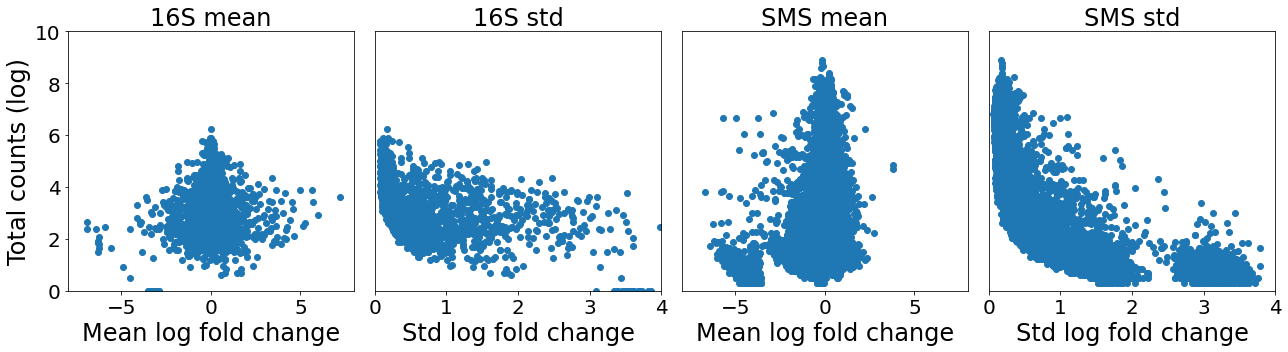

In [3]:
amp_totals = pd.Series(amp_biom.sum(axis='observation'), index=amp_biom.ids(axis='observation'))
wgs_totals = pd.Series(wgs_biom.sum(axis='observation'), index=wgs_biom.ids(axis='observation'))

fs = 24
fig, ax = plt.subplots(1, 4, figsize=(18, 5))
ax[0].scatter(amp_diffs.mean(axis=1), np.log10(amp_totals + 1))
ax[0].set_ylabel('Total counts (log)', fontsize=fs)
ax[0].set_xlabel('Mean log fold change', fontsize=fs)
ax[0].set_xlim([-8, 8])
ax[0].set_title('16S mean', fontsize=fs)

ax[1].scatter(amp_diffs.std(axis=1), np.log10(amp_totals + 1))
#ax[1].set_ylabel('Total counts (log)', fontsize=fs)
ax[1].set_xlabel('Std log fold change', fontsize=fs)
ax[1].set_yticks([])
ax[1].set_xlim([0, 4])
ax[1].set_title('16S std', fontsize=fs)

ax[2].scatter(wgs_diffs.mean(axis=1), np.log10(wgs_totals + 1))
#ax[2].set_ylabel('Total counts (log)', fontsize=fs)
ax[2].set_xlabel('Mean log fold change', fontsize=fs)
ax[2].set_xlim([-8, 8])
ax[2].set_yticks([])
ax[2].set_title('SMS mean', fontsize=fs)

ax[3].scatter(wgs_diffs.std(axis=1), np.log10(wgs_totals + 1))
#ax[3].set_ylabel('Total counts (log)', fontsize=fs)
ax[3].set_xlabel('Std log fold change', fontsize=fs)
ax[3].set_yticks([])
ax[3].set_xlim([0, 4])
ax[3].set_title('SMS std', fontsize=fs)

for a in ax:
    a.set_ylim([0, 10])
    a.tick_params(axis='x', labelsize=20)
    a.tick_params(axis='y', labelsize=20)
    
plt.tight_layout()

Let's first visualize the heatmaps of the amplicon abundances

Text(0.5, 51.0, 'Microbes')

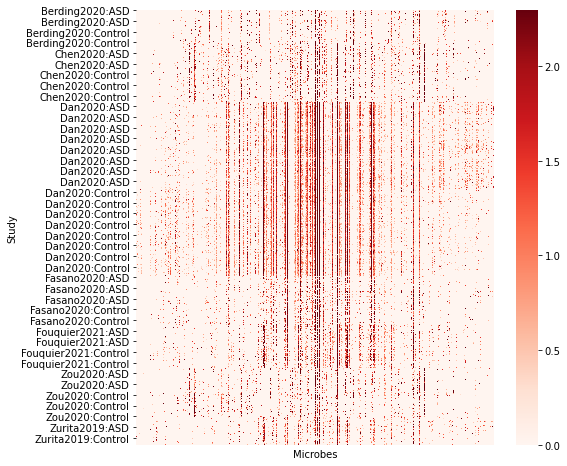

In [4]:
plt.figure(figsize=(8, 8))
amp_sorted_md = amp_md.sort_values(['Cohort', 'Status', 'Match_IDs'])
amp_sorted_table = amp_table.loc[amp_sorted_md.index]
amp_sorted_table['Study'] = amp_md.apply(lambda x: x['Cohort'] + ':' + x['Status'], axis=1)
amp_sorted_table = amp_sorted_table.set_index('Study')
amp_sorted_table = amp_sorted_table.loc[:, amp_stats.sort_values('mean').index]
sns.heatmap(np.log10(amp_sorted_table + 1), robust=True, cmap='Reds')
plt.xticks([])
plt.xlabel('Microbes')

# Reference Frame

Fit Gaussian mixture models to pick a better reference frame

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to

Text(0.5, 0, 'log fold change')

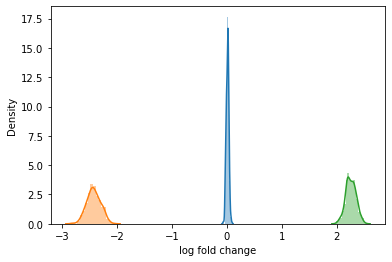

In [5]:
from util import solve, reorder, balance_thresholds
from plot import gaussian_mixture_plot
from sklearn.mixture import GaussianMixture

ast = amp_stats.copy()

# convert to clr coordinates
amp_clr_diffs = amp_diffs - amp_diffs.mean(axis=0)

gmod = GaussianMixture(n_components=3)
gmod.fit(X=amp_clr_diffs)

fig, ax = plt.subplots()
sns.distplot(gmod.means_[0], ax=ax)
sns.distplot(gmod.means_[1], ax=ax)
sns.distplot(gmod.means_[2], ax=ax)
plt.xlabel('log fold change')

In [6]:
from scipy.stats import multivariate_normal as mvn

# sorts by distribution, namely, left, middle and right
pdfs = np.vstack(
    [mvn.pdf(amp_clr_diffs.values, mean=gmod.means_[i], cov=gmod.covariances_[i])
     for i in np.argsort(gmod.means_.mean(axis=1))]
).T
cluster_labels = np.argmax(pdfs, axis=1)

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/scipy/stats/_multivariate.py:528: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, mean, psd.U, psd.log_pdet, psd.rank))


In [7]:
amp_stats.shape, amp_table.shape

((1472, 15), (692, 1472))

In [8]:
gm = np.sort(gmod.means_.mean(axis=1))

reference_frame = gm[1]  # set ANCOM-BC like delta

# Compute statistical tests for each data layer
# Here, we will only focus on the top 10% of the features
#amp_stats = ranking(amp_diffs, reference_frame=reference_frame, log_probs=True)
#wgs_stats = ranking(wgs_diffs, reference_percentile=50)  # TODO
amp_stats['cluster_id'] = cluster_labels

def cluster_f(x):
    if x == 0:
        return 'denom'
    if x == 1:
        return 'neutral'
    if x == 2:
        return 'num'
    return None

amp_stats['cluster_name'] = amp_stats['cluster_id'].apply(cluster_f) 

sort_col = 'mean'

# Remove taxa with few counts
idx = (amp_table > 0).sum(axis=0) > 3
amp_table = amp_table.loc[:, idx]
amp_stats = amp_stats.loc[amp_table.columns]

# Case-control classification

Compute clr transform on tables and sort by the ranking

In [9]:
amp_stats = amp_stats.sort_values(sort_col)
wgs_stats = wgs_stats.sort_values(sort_col)

amp_table = amp_table.loc[:, amp_stats.index]
wgs_table = wgs_table.loc[:, wgs_stats.index]

amp_ma = ma.array(amp_table.values, mask=amp_table.values == 0)
wgs_ma = ma.array(wgs_table.values, mask=wgs_table.values == 0)

amp_log = np.log(amp_table.values + 1)
wgs_log = np.log(wgs_table.values + 1)

amp_clr = amp_log - amp_log.mean(axis=1).reshape(-1, 1)
wgs_clr = wgs_log - wgs_log.mean(axis=1).reshape(-1, 1)

amp_clr = pd.DataFrame(amp_clr, index=amp_table.index, columns=amp_table.columns).fillna(0)
wgs_clr = pd.DataFrame(wgs_clr, index=wgs_table.index, columns=wgs_table.columns).fillna(0)

Compute differences between asd subjects and controls for each matching

In [10]:
amp_clr = pd.merge(amp_md[['Match_IDs', 'Status']], amp_clr, left_index=True, right_index=True)
wgs_clr = pd.merge(wgs_md[['Match_IDs', 'Status']], wgs_clr, left_index=True, right_index=True)

amp_clr = amp_clr.sort_values(by=['Status', 'Match_IDs'])
wgs_clr = wgs_clr.sort_values(by=['Status', 'Match_IDs'])

amp_asd = amp_clr.loc[amp_clr['Status'] == 'ASD']
amp_con = amp_clr.loc[amp_clr['Status'] == 'Control']

wgs_asd = wgs_clr.loc[wgs_clr['Status'] == 'ASD']
wgs_con = wgs_clr.loc[wgs_clr['Status'] == 'Control']

amp_asd_con = pd.DataFrame(
    amp_asd.iloc[:, 2:].values - amp_con.iloc[:, 2:].values,
    index=amp_asd['Match_IDs'], columns=amp_asd.columns[2:])
wgs_asd_con = pd.DataFrame(
    wgs_asd.iloc[:, 2:].values - wgs_con.iloc[:, 2:].values,
    index=wgs_asd['Match_IDs'], columns=wgs_asd.columns[2:])

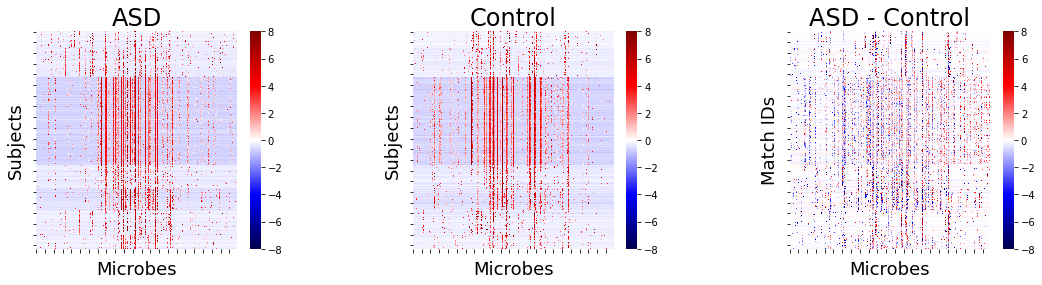

In [11]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

fig, ax = plt.subplots(1, 3, figsize=(18, 4))
sns.heatmap(amp_asd.iloc[:, 2:].values, cmap='seismic', 
            norm=MidpointNormalize(midpoint=0., vmin=-8, vmax=8),
            robust=False, ax=ax[0], cbar=True)
sns.heatmap(amp_con.iloc[:, 2:].values, cmap='seismic', 
            norm=MidpointNormalize(midpoint=0., vmin=-8, vmax=8),
            robust=False, ax=ax[1], cbar=True)
sns.heatmap(amp_asd_con, cmap='seismic', 
            norm=MidpointNormalize(midpoint=0., vmin=-8, vmax=8),
            robust=False, ax=ax[2])

titles = ['ASD', 'Control', 'ASD - Control']
for i, a in enumerate(ax):
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.set_xlabel('Microbes', fontsize=18)
    a.set_ylabel('Subjects', fontsize=18)
    a.set_title(titles[i], fontsize=24)

ax[2].set_ylabel('Match IDs', fontsize=18)

plt.subplots_adjust(wspace=0.5)
#plt.tight_layout()

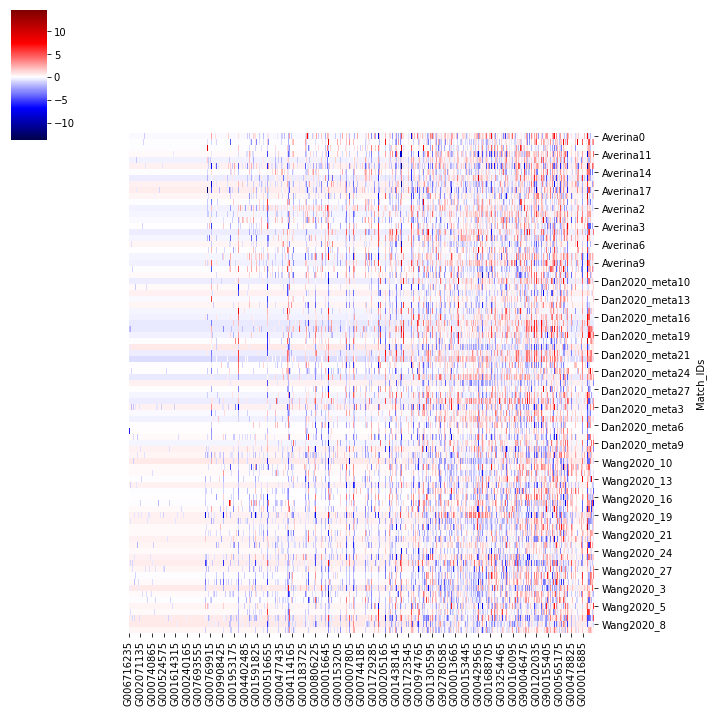

In [12]:
sns.clustermap(wgs_asd_con, cmap='seismic', figsize=(10, 10), norm=MidpointNormalize(midpoint=0.),
               row_cluster=False, col_cluster=False, robust=True)

Let's now perform classification.  We will select the top ASD associated microbes and the top control associated microbes, then compute their log-ratio, namely

$\textrm{log-ratio} = \log \frac{g(x_{asd})}{g(x_{control})}$

where $x_{asd}$ denotes the abundances of the top 200 ASD associated microbes and 
$x_{control}$ denotes the abundances of the top 200 control associated microbes.

We compute this log-ratio for each sample, and then we compute the difference between  matched ASD and Control samples.

In [13]:
def balance_classifier(table, md, stats, t=100, b=100):
    pairs = {}
    for n, pair in md.groupby('Match_IDs'):
        p = pair.sort_values('Status')
        asd, con = p.index[0], p.index[1]
        top = stats.tail(t).index
        bot = stats.head(b).index
        asd_lr = np.log(table.loc[asd, top] + 1).mean() - np.log(table.loc[asd, bot] + 1).mean()
        con_lr = np.log(table.loc[con, top] + 1).mean() - np.log(table.loc[con, bot] + 1).mean()
        pairs[n] = asd_lr - con_lr
    return pd.Series(pairs)

We are computing log-ratios per sample and plotting their distribution.

As we can see these log-ratios are heavily weighted towards the controls,
suggesting that these log-ratios form a *very* good classifier (i.e. there is no overlap with zero).

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


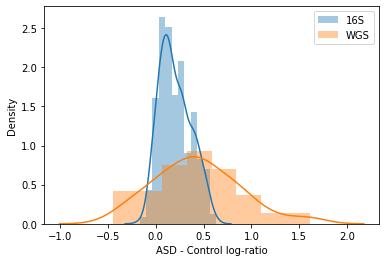

In [14]:
# use Gaussian mixture models way above to choose numerator / denominator
rs = amp_stats['cluster_name'].value_counts()
r = rs['denom']
s = rs['num']

amp_lrs = balance_classifier(amp_table, amp_md, amp_stats.sort_values(['cluster_name', 'mean'])['mean'], t=r, b=s)
wgs_lrs = balance_classifier(wgs_table, wgs_md, wgs_stats['mean'], t=200, b=200)

sns.distplot(amp_lrs, label='16S')
sns.distplot(wgs_lrs, label='WGS')
plt.xlabel('ASD - Control log-ratio')
plt.legend()

In [15]:
np.mean(amp_lrs > 0)

0.9046242774566474

In [16]:
np.mean(wgs_lrs > 0)

0.8554216867469879

Let's now overlay these results over the heatmaps

In [17]:
amp_stats_all['group'].value_counts()

neutral    712
num        591
denom      169
Name: group, dtype: int64

In [18]:
np.sum(amp_stats_all['5%'] > 0), np.sum(amp_stats_all['95%'] < 0)

(265, 210)

In [19]:
amp_stats_all.shape, amp_asd_con.shape

((1512, 28), (346, 1419))

In [20]:
len(set(amp_stats_all.index) & set(amp_asd_con))

1419

In [21]:
def consensus_f(x):
    if x['group'] == 'num' and x['cluster_name'] == 'num':
        return 'num'
    if x['group'] == 'denom' and x['cluster_name'] == 'denom':
        return 'denom'
    return 'neutral'
    
amp_stats['consensus'] = amp_stats.apply(consensus_f, axis=1)

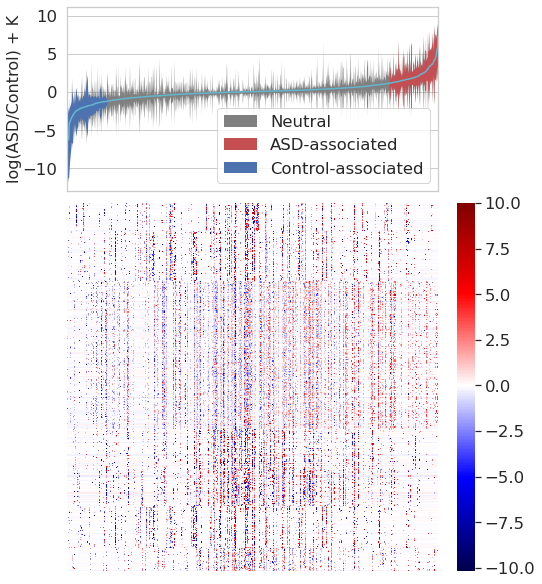

In [22]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

taxa_names = mapping['species']

fig = plt.figure(constrained_layout=True, figsize=(10, 8))
gs = fig.add_gridspec(3, 3)
ax1 = fig.add_subplot(gs[1:, :2])
#ax2 = fig.add_subplot(gs[1:, 2])
ax3 = fig.add_subplot(gs[0, :2])

amp_stats_ = amp_stats.sort_values('mean')
#amp_stats_ = amp_stats_all.loc[amp_asd_con.columns].sort_values('mean')
#amp_stats_ = amp_stats_.query("std < 1")
X = amp_asd_con.loc[:, amp_stats_.index]
#X.columns = list(map(lambda x: np.unique(taxa_names.loc[x])[0], X.columns))
g = sns.heatmap(X, 
                robust=False, cbar=True,
                cmap='seismic', ax=ax1, 
                norm=MidpointNormalize(midpoint=0.))
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_ylabel('')
#ax = ax2
#sns.regplot(amp_lrs.values, np.arange(len(amp_lrs)), ax=ax, fit_reg=False)
#ax.set_yticks([])
#ax.set_ylim([0, len(amp_lrs)])
#ax.set_xlim([-3, 3])
#ax.vlines(0, 0, len(amp_lrs), 'r')
#ax.set_xlabel('ASD:Control Balance', 
#               fontsize=16)


ax = ax3
## rank plot
lr = amp_stats_
sort_col = 'mean'
threshold = 1e-3 / len(lr)
idx = np.arange(len(lr))
lr = lr.sort_values(sort_col)
cmap = matplotlib.cm.get_cmap('seismic')
lr['index'] = idx
ax.fill_between(lr['index'], lr['5%'], lr['95%'], fc='#808080', label='Neutral', lw=0)
i = lr['consensus'] == 'num'
ax.fill_between(lr.loc[i, 'index'], lr.loc[i, '5%'], lr.loc[i, '95%'], fc='r', lw=0,
                label='ASD-associated')

i = lr['consensus'] == 'denom'
ax.fill_between(lr.loc[i, 'index'], lr.loc[i, '5%'], lr.loc[i, '95%'], fc='b', lw=0,
                label='Control-associated')    
ax.plot(lr['index'], lr['mean'], c='c')

ax.set_ylabel('log(ASD/Control) + K', fontsize=16, rotation=90, labelpad=0)
ax.set_xticks([])
ax.set_xlim([0, len(amp_stats_)])
#ax.set_ylim(-7.5, 7.5)
ax.legend(loc=4)
#plt.tight_layout()

In [23]:
amp_stats.to_csv('../figures/data/Figure2/rank_stats.csv')
X.to_csv('../figures/data/Figure2/case_control_diffs.csv')